In [11]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# 1. Configuration des chemins
# On remonte d'un cran pour atteindre la racine du projet
ROOT_DIR = Path("..").resolve()
sys.path.append(str(ROOT_DIR))

# 2. Rechargement automatique (Autoreload)
%load_ext autoreload
%autoreload 2

# 3. Import du module
from src.data_utils import MultilingualIndexer

print(f"Racine du projet configurée : {ROOT_DIR}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Racine du projet configurée : C:\Users\benic\Documents\Projet_DL_Translation


In [5]:
# Instanciation de l'indexeur
indexer = MultilingualIndexer(root_dir=ROOT_DIR)

In [ ]:
# Liste des archives à traiter
archives = [
    "mtedx_fr.tgz", 
    "mtedx_fr-en.tgz", 
    "mtedx_fr-es.tgz", 
    "mtedx_fr-pt.tgz"
]

print("--- Extraction des métadonnées ---")
# Cette étape est rapide (pas d'extraction audio lourde)
indexer.extract_metadata_files(archives)
print("--- Extraction terminée ---")

--- Début de l'extraction des métadonnées ---
Extraction des métadonnées de mtedx_fr.tgz...
Extraction des métadonnées de mtedx_fr-en.tgz...
Extraction des métadonnées de mtedx_fr-es.tgz...
Extraction des métadonnées de mtedx_fr-pt.tgz...
--- Extraction terminée ---


In [6]:
# Étape 2 : Exploration physique des dossiers extraits
splits = ['train', 'valid', 'test']
indexer.present_raw_dataset(splits=splits)

=== PRÉSENTATION DU DATASET (Fichiers Bruts extraits) ===

📁 SPLIT : TRAIN
  🎬 Vidéos uniques (Source FR) : 949
  ⏱️ Segments audio totaux    : 116045
  📝 Contenu des fichiers textes :
     - Français (.fr) : 116045 lignes
     - Traduction EN (.en) : 30171 lignes
     - Traduction ES (.es) : 20826 lignes
     - Traduction PT (.pt) : 13286 lignes

📁 SPLIT : VALID
  🎬 Vidéos uniques (Source FR) : 12
  ⏱️ Segments audio totaux    : 1036
  📝 Contenu des fichiers textes :
     - Français (.fr) : 1036 lignes
     - Traduction EN (.en) : 1036 lignes
     - Traduction ES (.es) : 1036 lignes
     - Traduction PT (.pt) : 1036 lignes

📁 SPLIT : TEST
  🎬 Vidéos uniques (Source FR) : 10
  ⏱️ Segments audio totaux    : 1059
  📝 Contenu des fichiers textes :
     - Français (.fr) : 1059 lignes
     - Traduction EN (.en) : 1059 lignes
     - Traduction ES (.es) : 1059 lignes
     - Traduction PT (.pt) : 1059 lignes


In [7]:
try:
    # Création du DataFrame fusionné (FR + Traductions)
    # C'est ici que la magie du Lazy Loading et des chemins wav/vtt opère
    for split in splits:
        df_master = indexer.create_master_index(split)
        print(f"\n✅ Index Maître généré avec succès en mémoire pour le split : {split}\n")
        if df_master is not None:
            indexer.create_specialized_datasets(split)
            print(f"✅ Fichiers spécialisés créés pour le split : {split}\n")

except Exception as e:
    print(f"❌ Erreur critique lors de la création de l'index : {e}")
    # Astuce : On raise l'erreur pour arrêter l'exécution des cellules suivantes si on fait 'Run All'
    raise e

Construction de l'Index Maitre pour : train

✅ Index Maître généré avec succès en mémoire pour le split : train

✅ Fichiers spécialisés créés pour le split : train

Construction de l'Index Maitre pour : valid

✅ Index Maître généré avec succès en mémoire pour le split : valid

✅ Fichiers spécialisés créés pour le split : valid

Construction de l'Index Maitre pour : test

✅ Index Maître généré avec succès en mémoire pour le split : test

✅ Fichiers spécialisés créés pour le split : test



# Étape 4 : Analyse et Présentation des Datasets Générés

Suite à l'extraction et au croisement des données, nous avons généré 3 types de fichiers CSV dans `data/processed/`. Voici leur rôle dans notre processus :

### 1. Les Master Index (`master_train.csv`, `master_valid.csv`, `master_test.csv`)
- **Rôle :** C'est la base de données brute et complète. Elle contient tous les segments temporels, même ceux qui n'ont aucune traduction.
- **Colonnes clés :** `segment_id`, `video_id`, `start_time`, `end_time`, `wav_path`, `vtt_path`, `text_fr`, `text_en`, `text_es`, `text_pt`.

### 2. Les Datasets ASR (`train_asr_fr.csv`, etc.)
- **Rôle :** Utilisés **uniquement pour la Transcription (ASR)** avec Whisper. On a retiré toutes les colonnes de langues étrangères pour ne garder que l'audio et la transcription française.
- **Colonnes :** `segment_id`, `video_id`, `start_time`, `end_time`, `wav_path`, `text_fr`.

### 3. Les Datasets NMT (`train_nmt_fr_en.csv`, `train_nmt_fr_es.csv`, etc.)
- **Rôle :** Utilisés pour **l'entraînement du modèle de Traduction (NMT)**. Ils ne contiennent que les paires parfaites (une phrase FR associée à sa traduction cible). Les segments sans traduction ont été exclus.
- **Colonnes :** `segment_id`, `text_fr`, `text_en` (ou `es`, `pt`).

--- 📊 Bilan Volumétrique et Déperdition de Traduction ---


,Split,Videos,Segments (FR),Heures Audio,Duree moy/seg (s),Paires FR-EN,% EN (vs FR),Paires FR-ES,% ES (vs FR),Paires FR-PT,% PT (vs FR)
0,train,949,116045,175.83,5.45,30053,25.90,20723,17.86,13217,11.39
1,valid,12,1036,1.81,6.28,1035,99.90,1034,99.81,1035,99.90
2,test,10,1059,1.55,5.28,1058,99.91,1057,99.81,1058,99.91


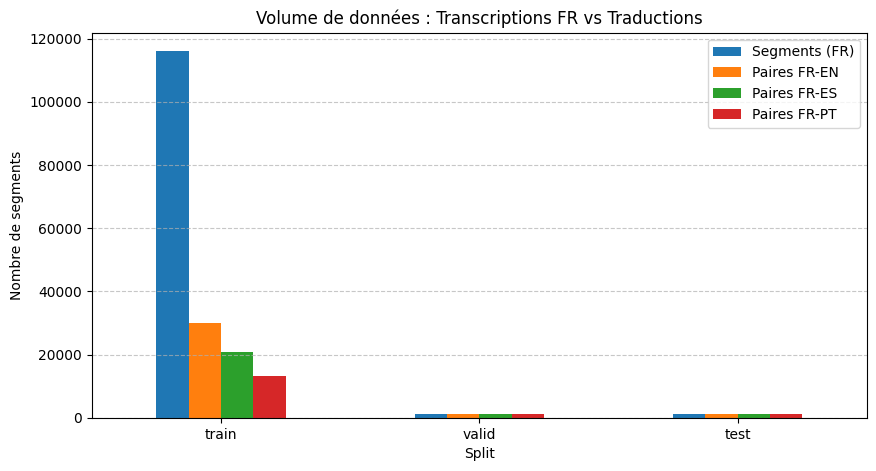

In [10]:
print("--- 📊 Bilan Volumétrique et Déperdition de Traduction ---")
df_analysis = indexer.analyze_dataset(splits)
display(df_analysis)

# Visualisation rapide de la déperdition (Combien de phrases FR sont traduites ?)
if not df_analysis.empty:
    df_plot = df_analysis.set_index('Split')[['Segments (FR)', 'Paires FR-EN', 'Paires FR-ES', 'Paires FR-PT']]
    df_plot.plot(kind='bar', figsize=(10, 5), title="Volume de données : Transcriptions FR vs Traductions")
    plt.ylabel("Nombre de segments")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [9]:
print("--- 🔍 Échantillons des fichiers générés (Split : TRAIN) ---")

# 1. Aperçu du Master
print("\n1️⃣ MASTER INDEX (Contient des 'NaN' là où la traduction manque) :")
df_master_train = pd.read_csv(ROOT_DIR / "data" / "processed" / "master_train.csv")
display(df_master_train.head(3))

# 2. Aperçu du Dataset ASR
print("\n2️⃣ DATASET ASR (Optimisé pour Whisper - Audio + FR) :")
df_asr_train = pd.read_csv(ROOT_DIR / "data" / "processed" / "train_asr_fr.csv")
display(df_asr_train.head(3))

# 3. Aperçu du Dataset NMT (Exemple Français -> Anglais)
print("\n3️⃣ DATASET NMT FR-EN (Optimisé pour le modèle de traduction - Paires alignées) :")
df_nmt_en = pd.read_csv(ROOT_DIR / "data" / "processed" / "train_nmt_fr_en.csv")
display(df_nmt_en.head(3))

--- 🔍 Échantillons des fichiers générés (Split : TRAIN) ---

1️⃣ MASTER INDEX (Contient des 'NaN' là où la traduction manque) :


,segment_id,video_id,start_time,end_time,wav_path,text_fr,text_en,text_es,text_pt
0,0-DmpK7Di0c_0000,0-DmpK7Di0c,8.57,9.45,data\temp\fr-fr\data\train\wav\0-DmpK7Di0c.flac,"Mesdames et messieurs, bonjour.",NaN,"Señoras y señores, buenos días.","Senhoras e senhores, bom dia."
1,0-DmpK7Di0c_0001,0-DmpK7Di0c,9.91,12.93,data\temp\fr-fr\data\train\wav\0-DmpK7Di0c.flac,"Je vais partager avec vous, en français, ma pa...",NaN,"Voy a compartir mi pasión con Uds., en francés...","Vou falar-vos, em francês, da minha paixão: a ..."
2,0-DmpK7Di0c_0002,0-DmpK7Di0c,15.11,25.47,data\temp\fr-fr\data\train\wav\0-DmpK7Di0c.flac,Tout ceci commence par une anecdote troublante...,NaN,Todo comienza con una anécdota inquietante que...,Tudo isto começa por uma história desconcertan...



2️⃣ DATASET ASR (Optimisé pour Whisper - Audio + FR) :


,segment_id,video_id,start_time,end_time,wav_path,text_fr
0,0-DmpK7Di0c_0000,0-DmpK7Di0c,8.57,9.45,data\temp\fr-fr\data\train\wav\0-DmpK7Di0c.flac,"Mesdames et messieurs, bonjour."
1,0-DmpK7Di0c_0001,0-DmpK7Di0c,9.91,12.93,data\temp\fr-fr\data\train\wav\0-DmpK7Di0c.flac,"Je vais partager avec vous, en français, ma pa..."
2,0-DmpK7Di0c_0002,0-DmpK7Di0c,15.11,25.47,data\temp\fr-fr\data\train\wav\0-DmpK7Di0c.flac,Tout ceci commence par une anecdote troublante...



3️⃣ DATASET NMT FR-EN (Optimisé pour le modèle de traduction - Paires alignées) :


,segment_id,text_fr,text_en
0,0SFQize20uI_0000,"Je m'appelle Julien Le Breton et, comme mon no...",I'm Julien Le Breton and as my name doesn't su...
1,0SFQize20uI_0001,"Là, je vous présente Leptomyrmex et ici, Rhyti...","Here, I'd like to introduce you to Leptomyrmex..."
2,0SFQize20uI_0002,Ce sont deux espèces de fourmis endémiques de ...,These are two ant species native to New Caledo...
